In [37]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from tqdm.auto import tqdm, trange
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

# Lots of small/large numbers involved in these calculations, so
# need to use 64-bit mode
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
from jax import random

from binary_jax import *
from analysis_jax import *
from noise import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC**3)
gamma_s = jnp.array(7 / 3)
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)


# @jax.jit
def logL_4d(x):
    gamma_s, c_f, M_chirp_MSUN, tT_c = x
    dd_h = DynamicDress(
        gamma_s,
        c_f,
        M_chirp_MSUN * MSUN,
        dd_s.q,  # fixed
        dd_s.Phi_c,  # fixed
        tT_c,
        dd_s.dL_iota,  # value doesn't matter
        get_f_isco(get_m_1(M_chirp_MSUN * MSUN, dd_s.q))
    )
    f_h = jnp.maximum(dd_s.f_c, dd_h.f_c)
    return loglikelihood(dd_h, dd_s, f_l, f_h, 3000, 3000)

r_gamma_s = 1.2e-1
r_c_f = 2.5e-1
r_M_chirp_MSUN = 1.2e-4
d_tT_c = 170

labels = (
    r"$\gamma_s$",
    r"$c_f$ [?]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\tilde{t}_c$ [s]"
)

def ptform(u):
    return jnp.array([
        dd_s.gamma_s * (1 + r_gamma_s * (2 * u[0] - 1)),
        dd_s.c_f * (1 + r_c_f * (2 * u[1] - 1)),
        dd_s.M_chirp / MSUN * (1 + r_M_chirp_MSUN * (2 * u[2] - 1)),
        d_tT_c * (2 * u[3] - 1)
    ])

In [42]:
# Load nested sampling results
with open('4d-sampler.pkl', 'rb') as input:
    sampler = pickle.load(input)

# Get sample covariance for proposal distribution
results = sampler.results
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
cov = dyfunc.mean_and_cov(samples, weights)[1]

## MH

From https://rlouf.github.io/post/jax-random-walk-metropolis/.

In [49]:
def logL_mh(x):
    gamma_s, c_f, M_chirp_MSUN, tT_c = x
    dd_h = DynamicDress(
        gamma_s,
        c_f,
        M_chirp_MSUN * MSUN,
        dd_s.q,  # fixed
        dd_s.Phi_c,  # fixed
        tT_c,
        dd_s.dL_iota,  # value doesn't matter
        get_f_isco(get_m_1(M_chirp_MSUN * MSUN, dd_s.q))
    )
    f_c_h = get_f_isco(get_m_1(dd_h.M_chirp, dd_h.q))
    return loglikelihood(dd_h, dd_s, f_l, f_c, 3000, 3000)


labels = (
    r"$\gamma_s$",
    r"$c_f$ [?]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\tilde{t}_c$ [s]"
)

initial_position = truths = jnp.array([
    dd_s.gamma_s, dd_s.c_f, dd_s.M_chirp / MSUN, dd_s.tT_c
])

In [50]:
logL_mh(initial_position)

DeviceArray(42.2626203, dtype=float64)

In [52]:
logL_mh(initial_position)

Buffer(42.2626203, dtype=float64)

Run MH

In [74]:
# jump_cov = covs[-1] * 0.01
# jump_cov = jnp.array(np.cov(positions.T).copy()) * 0.02
jump_cov = cov * 0.003

def rw_metropolis_kernel(rng_key, logpdf, position, log_prob):
    """Moves the chain by one step using the Random Walk Metropolis algorithm.
  
    Attributes
    ----------
    rng_key: jax.random.PRNGKey
      Key for the pseudo random number generator.
    logpdf: function
      Returns the log-probability of the model given a position.
    position: np.ndarray, shape (n_dims,)
      The starting position.
    log_prob: float
      The log probability at the starting position.

    Returns
    -------
    Tuple
        The next positions of the chains along with their log probability.
    """
    key, subkey = jax.random.split(rng_key)
    move_proposals = jax.random.multivariate_normal(
        key,
        mean=jnp.zeros_like(position),
        cov=jump_cov,
    )
    proposal = position + move_proposals
    
    if jnp.any(proposal[:3] < 0):
        # Reject out-of-bounds proposal!
        return position, log_prob
    
    proposal_log_prob = logpdf(proposal)

    log_uniform = jnp.log(jax.random.uniform(subkey))
    do_accept = log_uniform < proposal_log_prob - log_prob

    position = jnp.where(do_accept, proposal, position)
    log_prob = jnp.where(do_accept, proposal_log_prob, log_prob)
    return position, log_prob


def rw_metropolis_sampler(rng_key, n_samples, logpdf, initial_position):
    """Generate samples using the Random Walk Metropolis algorithm.
    Attributes
    ----------
    rng_key: jax.random.PRNGKey
        Key for the pseudo random number generator.
    n_samples: int
        Number of samples to generate per chain.
    logpdf: function
      Returns the log-probability of the model given a position.
    inital_position: np.ndarray (n_dims, n_chains)
      The starting position.
    Returns
    -------
    (n_samples, n_dim)
    """
    positions = [initial_position]
    log_probs = [logpdf(initial_position)]
    
    n_accepts = 0
    with tqdm(total=n_samples) as pbar:
        while n_accepts < n_samples:
            _, rng_key = jax.random.split(rng_key)
            position, log_prob = rw_metropolis_kernel(
                rng_key, logpdf, positions[-1], log_probs[-1]
            )
            if not jnp.all(position == positions[-1]):
                n_accepts += 1
                pbar.update(1)
                pbar.set_description(f"{n_accepts / len(positions):.4f}")

            positions.append(position)
            log_probs.append(log_prob)

    return jnp.stack(positions), jnp.stack(log_probs)

In [75]:
rng_key = jax.random.PRNGKey(7423)
n_samples = 10000
positions, log_probs = rw_metropolis_sampler(
    rng_key, n_samples, logL_mh, initial_position
)
print(f"Acceptance rate: {n_samples / len(positions)}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Acceptance rate: 0.21056621254553495


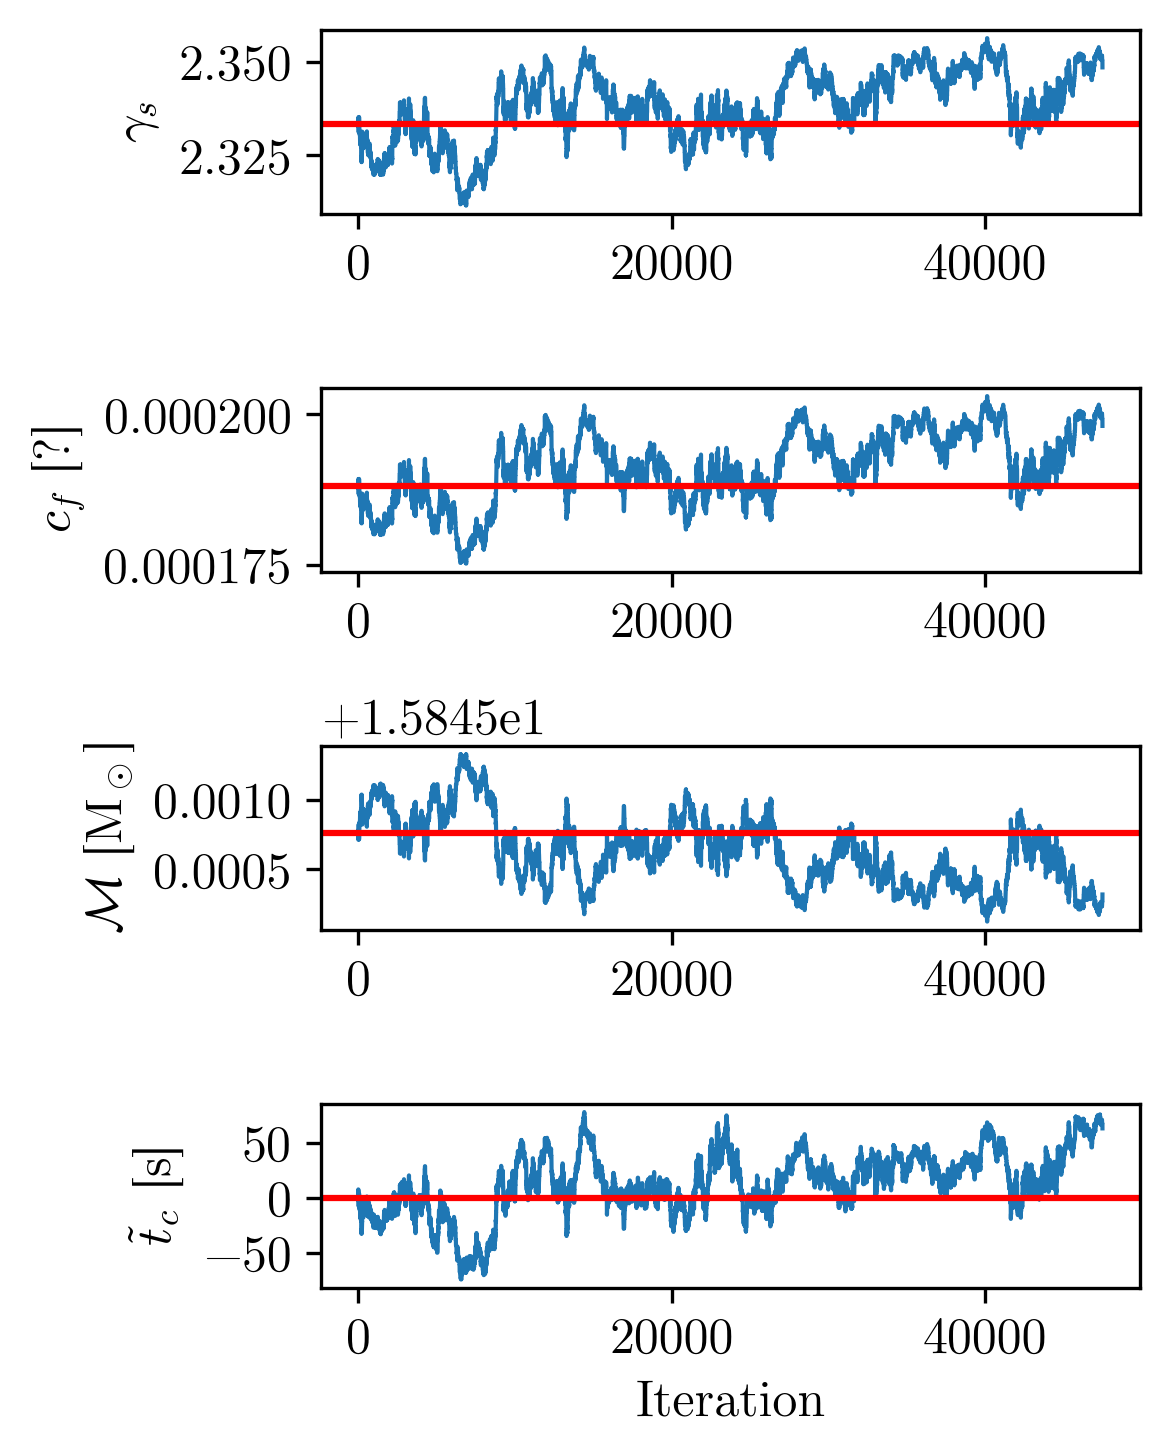

In [76]:
fig, axes = plt.subplots(len(truths), 1, figsize=(4, 5))

for i, ax in enumerate(axes):
    ax.plot(positions[:, i], linewidth=1)
    ax.axhline(truths[i], color="r")
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("Iteration")
fig.tight_layout()

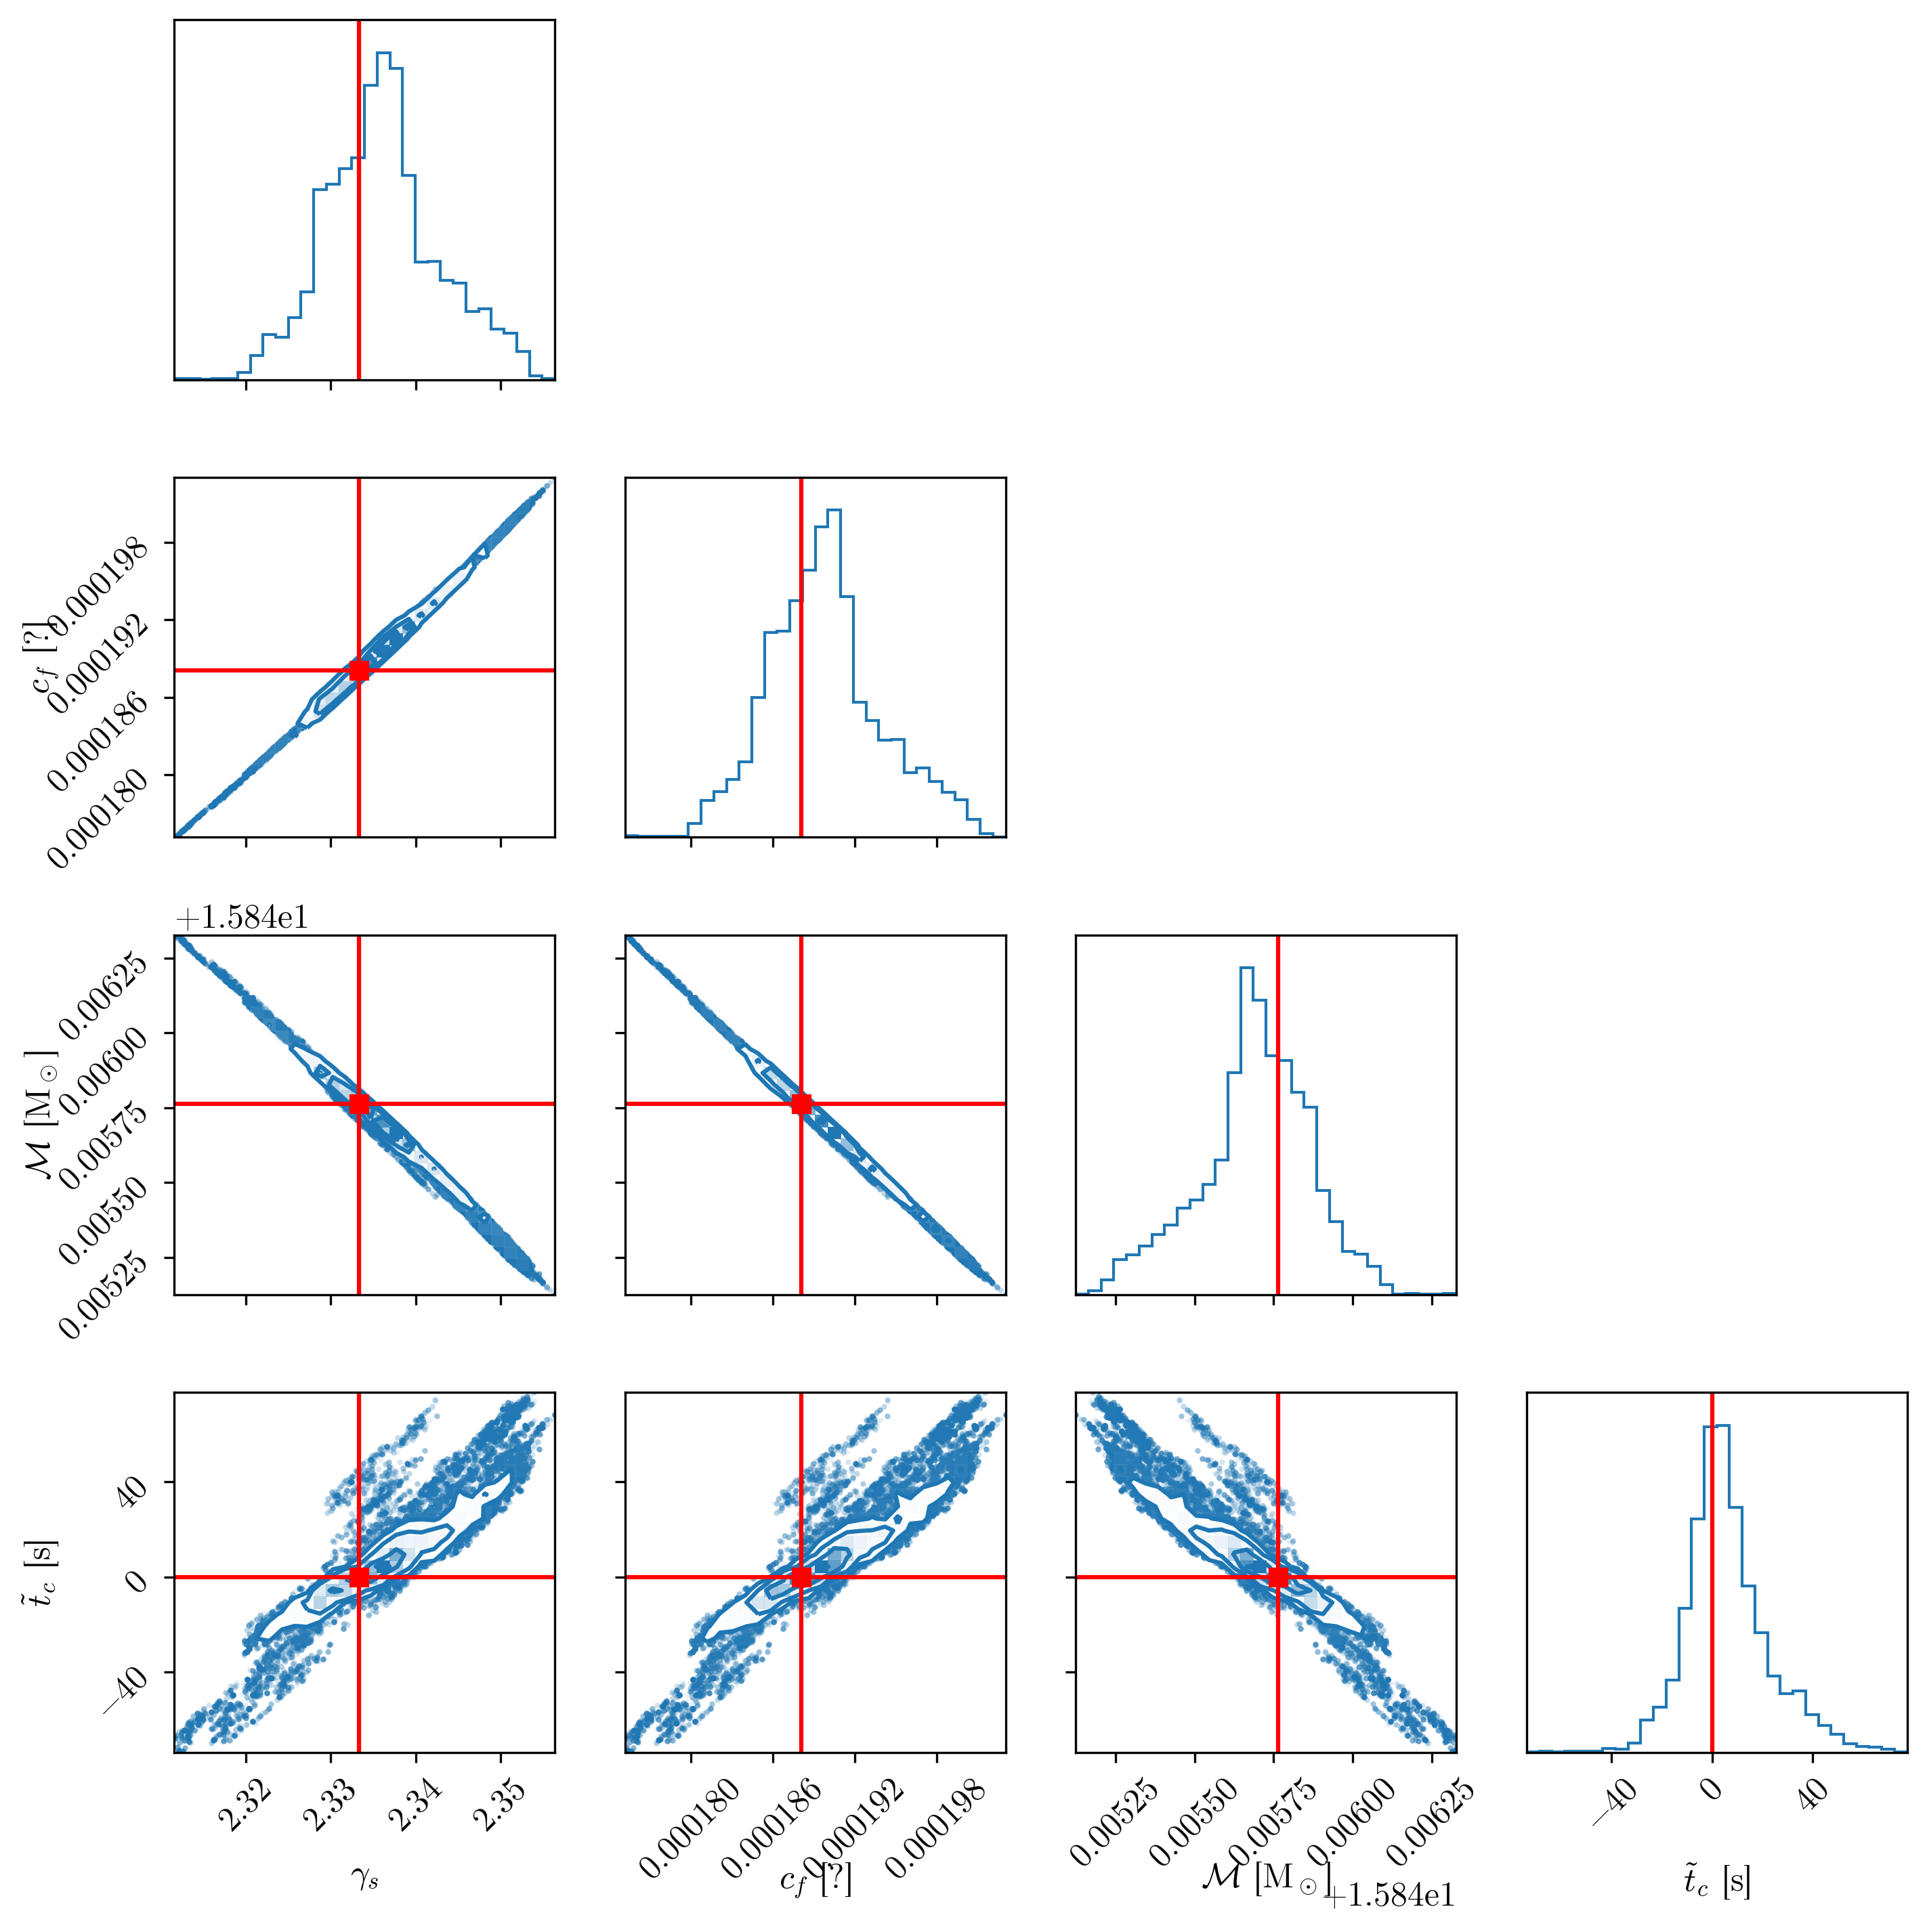

In [81]:
corner(
    np.array(positions),
#     smooth1d=True, smooth=True,
    bins=30,
    truths=truths,
    labels=labels,
    color="C0",
    truth_color="r",
    weights=jnp.exp(log_probs)
);
plt.tight_layout()